<a href="https://colab.research.google.com/github/mehrzadian/Compositional-Retrieval/blob/main/synthetic_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We can verify that we've been assigned a GPU and view its specifications:

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun May 25 05:57:49 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   60C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

We'll employ several popular Python packages to fine-tune the Whisper model.
We'll use `datasets[audio]` to download and prepare our training data, alongside
`transformers` and `accelerate` to load and train our Whisper model.
We'll also require the `soundfile` package to pre-process audio files,
`evaluate` and `jiwer` to assess the performance of our model, and
`tensorboard` to log our metrics. Finally, we'll use `gradio` to build a
flashy demo of our fine-tuned model.

In [2]:
!pip install --upgrade --quiet pip
!pip install --upgrade --quiet datasets[audio] transformers accelerate evaluate jiwer tensorboard gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 68.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 135.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 95.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 MB 61.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 57.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 131.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 57.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 142.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 140.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 45.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 69.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56

We strongly advise you to upload model checkpoints directly the [Hugging Face Hub](https://huggingface.co/)
whilst training. The Hub provides:
- Integrated version control: you can be sure that no model checkpoint is lost during training.
- Tensorboard logs: track important metrics over the course of training.
- Model cards: document what a model does and its intended use cases.
- Community: an easy way to share and collaborate with the community!

Linking the notebook to the Hub is straightforward - it simply requires entering your
Hub authentication token when prompted. Find your Hub authentication token [here](https://huggingface.co/settings/tokens):

In [16]:
from huggingface_hub import notebook_login

notebook_login()

## Load Dataset

Using 🤗 Datasets, downloading and preparing data is extremely simple.
We can download and prepare the Common Voice splits in just one line of code.

First, ensure you have accepted the terms of use on the Hugging Face Hub: [mozilla-foundation/common_voice_11_0](https://huggingface.co/datasets/mozilla-foundation/common_voice_11_0). Once you have accepted the terms, you will have full access to the dataset and be able to download the data locally.

Since Hindi is very low-resource, we'll combine the `train` and `validation`
splits to give approximately 8 hours of training data. We'll use the 4 hours
of `test` data as our held-out test set:

In [4]:
from datasets import load_dataset, DatasetDict

common_voice = DatasetDict()

common_voice["train"] = load_dataset("mozilla-foundation/common_voice_11_0", "fa", split="train+validation")
common_voice["test"] = load_dataset("mozilla-foundation/common_voice_11_0", "fa", split="test")

print(common_voice)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/14.4k [00:00<?, ?B/s]

common_voice_11_0.py:   0%|          | 0.00/8.13k [00:00<?, ?B/s]

languages.py:   0%|          | 0.00/3.44k [00:00<?, ?B/s]

release_stats.py:   0%|          | 0.00/60.9k [00:00<?, ?B/s]

The repository for mozilla-foundation/common_voice_11_0 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/mozilla-foundation/common_voice_11_0.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


n_shards.json:   0%|          | 0.00/12.2k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


fa_train_0.tar:   0%|          | 0.00/669M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


fa_dev_0.tar:   0%|          | 0.00/316M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


fa_test_0.tar:   0%|          | 0.00/403M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


fa_other_0.tar:   0%|          | 0.00/670M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


fa_invalidated_0.tar:   0%|          | 0.00/567M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


train.tsv:   0%|          | 0.00/6.29M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


dev.tsv:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


test.tsv:   0%|          | 0.00/2.41M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


other.tsv:   0%|          | 0.00/5.67M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


invalidated.tsv:   0%|          | 0.00/3.49M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]


Reading metadata...: 0it [00:00, ?it/s]
Reading metadata...: 10467it [00:00, 104656.88it/s]
Reading metadata...: 26951it [00:00, 117090.50it/s]


Generating validation split: 0 examples [00:00, ? examples/s]


Reading metadata...: 10288it [00:00, 134125.95it/s]


Generating test split: 0 examples [00:00, ? examples/s]


Reading metadata...: 10288it [00:00, 139395.07it/s]


Generating other split: 0 examples [00:00, ? examples/s]


Reading metadata...: 0it [00:00, ?it/s]
Reading metadata...: 24401it [00:00, 138748.71it/s]


Generating invalidated split: 0 examples [00:00, ? examples/s]


Reading metadata...: 0it [00:00, ?it/s]
Reading metadata...: 13793it [00:00, 122254.46it/s]


DatasetDict({
    train: Dataset({
        features: ['client_id', 'path', 'audio', 'sentence', 'up_votes', 'down_votes', 'age', 'gender', 'accent', 'locale', 'segment'],
        num_rows: 37239
    })
    test: Dataset({
        features: ['client_id', 'path', 'audio', 'sentence', 'up_votes', 'down_votes', 'age', 'gender', 'accent', 'locale', 'segment'],
        num_rows: 10288
    })
})


Most ASR datasets only provide input audio samples (`audio`) and the
corresponding transcribed text (`sentence`). Common Voice contains additional
metadata information, such as `accent` and `locale`, which we can disregard for ASR.
Keeping the notebook as general as possible, we only consider the input audio and
transcribed text for fine-tuning, discarding the additional metadata information:

In [5]:
from IPython.display import Audio, display

example1 = next(iter(common_voice["train"]))

print('Speaker id: ', example1['client_id'])

print('Audio: ')
display(Audio(example1['audio']['array'], rate=example1['audio']['sampling_rate']))

Speaker id:  6669fa691c805f4cb2eb2ab7b19d5f56308fe8baf6d03897ec0aa5dd3e8219e0ae0b7fe894c09a118cde2d5d88b72503576cf470e8d4b3d0b83aa59f62287933
Audio: 


In [21]:
!pip install --upgrade --quiet git+https://github.com/huggingface/diarizers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 898.7/898.7 kB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [diarizers]


In [22]:
pip show diarizers

Name: diarizers
Version: 0.1
Summary: diarizers
Home-page: https://github.com/kamilakesbi/diarizers
Author: The HuggingFace team
Author-email: kamil@huggingface.co
License: Apache
Location: /usr/local/lib/python3.11/dist-packages
Requires: accelerate, audiomentations, black, datasets, denoiser, filelock, flake8, importlib_metadata, isort, numpy, pyannote.audio, torch, transformers
Required-by: 


In [8]:
!pip install --quiet pyannote.audio

In [10]:
!pip show pyannote.audio

Name: pyannote.audio
Version: 1.1.2
Summary: Neural building blocks for speaker diarization
Home-page: https://github.com/pyannote/pyannote-audio
Author: Hervé Bredin
Author-email: bredin@limsi.fr
License: UNKNOWN
Location: /usr/local/lib/python3.11/dist-packages
Requires: cachetools, librosa, pandas, pescador, Pillow, pyannote.core, pyannote.database, pyannote.metrics, pyannote.pipeline, pyYAML, scikit-learn, sortedcollections, sortedcontainers, soundfile, tensorboard, tqdm
Required-by: diarizers


In [14]:
!pip uninstall pyannote.audio diarizers -y

Found existing installation: pyannote.audio 3.1.1
Uninstalling pyannote.audio-3.1.1:
  Successfully uninstalled pyannote.audio-3.1.1
Found existing installation: diarizers 0.1
Uninstalling diarizers-0.1:
  Successfully uninstalled diarizers-0.1


In [20]:
!pip install --quiet pyannote.audio==2.1.1

  Preparing metadata (setup.py) ... done
ERROR: Ignored the following yanked versions: 2.0.0
ERROR: Could not find a version that satisfies the requirement torchaudio<1.0,>=0.10 (from pyannote-audio) (from versions: 2.0.1, 2.0.2, 2.1.0, 2.1.1, 2.1.2, 2.2.0, 2.2.1, 2.2.2, 2.3.0, 2.3.1, 2.4.0, 2.4.1, 2.5.0, 2.5.1, 2.6.0, 2.7.0)
ERROR: No matching distribution found for torchaudio<1.0,>=0.10


In [4]:
from diarizers import SyntheticDataset, SyntheticDatasetConfig

synthetic_dataset_config = SyntheticDatasetConfig(
    dataset_name='mozilla-foundation/common_voice_11_0',
    subset='train',
    split='fa',
    audio_column_name = "audio",
    speaker_column_name = "client_id",
    nb_speakers_from_dataset=-1,
    min_samples_per_speaker=10,
    sample_rate=16000,
)

synthetic_dataset = SyntheticDataset(synthetic_dataset_config)

nb speakers in dataset to keep: 111


Filter (num_proc=2):   0%|          | 0/26951 [00:00<?, ? examples/s]

100%|██████████| 111/111 [00:00<00:00, 214448.52it/s]
/usr/local/lib/python3.11/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/snakers4/silero-vad/zipball/master" to /root/.cache/torch/hub/master.zip


### Load WhisperTokenizer

The Whisper model outputs a sequence of _token ids_. The tokenizer maps each of these token ids to their corresponding text string. For Hindi, we can load the pre-trained tokenizer and use it for fine-tuning without any further modifications. We simply have to
specify the target language and the task. These arguments inform the
tokenizer to prefix the language and task tokens to the start of encoded
label sequences:

In [5]:
print('Speakers that will be used for sampling: ', len(synthetic_dataset.speakers_to_sample_from))

Speakers that will be used for sampling:  111


### Combine To Create A WhisperProcessor

In [6]:
synthetic_dataset_config = SyntheticDatasetConfig(
    dataset_name='mozilla-foundation/common_voice_11_0',
    subset='train',
    split='fa',
    min_samples_per_speaker=10,
    audio_column_name = "audio",
    speaker_column_name = "client_id",
    nb_speakers_from_dataset=3,
    num_meetings=2,
    nb_speakers_per_meeting=3,
    segments_per_meeting=16,
    overlap_proba=0,
    silence_proba=0,
    num_proc=1,
)

synthetic_dataset = SyntheticDataset(synthetic_dataset_config).generate()

nb speakers in dataset to keep: 3


Filter:   0%|          | 0/26951 [00:00<?, ? examples/s]

100%|██████████| 3/3 [00:00<00:00, 6232.25it/s]
Downloading: "https://github.com/snakers4/silero-vad/zipball/master" to /root/.cache/torch/hub/master.zip
100%|██████████| 2/2 [00:00<00:00, 91.22it/s]
Parameter 'function'=<bound method SyntheticDataset.concatenate of <diarizers.data.synthetic_pipeline.SyntheticDataset object at 0x780d4520e350>> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

In [8]:
import matplotlib.pyplot as plt
import numpy as np

def plot_meeting(dataset, sample=0):

    timestamps_start = dataset[sample]['timestamps_start']
    timestamps_end = dataset[sample]['timestamps_end']
    speakers = dataset[sample]['speakers']
    print(len(timestamps_start))
    speaker_labels = list(set(speakers))

    per_speaker_timestamps = {}

    for speaker_to_filter in speaker_labels:

        indices = [i for i, spk in enumerate(speakers) if spk == speaker_to_filter]

        timestamps_start_spk = [timestamps_start[i] for i in indices]
        timestamps_end_spk = [timestamps_end[i] - timestamps_start[i] for i in indices]

        per_speaker_timestamps[speaker_to_filter] = list(zip(timestamps_start_spk, timestamps_end_spk))

    # Set up the figure and axis
    fig, ax = plt.subplots(figsize = (10, 5))
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
    colors += ['#{:06x}'.format(np.random.randint(0, 16777215)) for _ in range(len(speaker_labels) - 4)]

    i = 0
    labels = []
    label_positions = []

    for key, value in per_speaker_timestamps.items():
        ax.broken_barh(value, (0.3*i, 0.5), facecolors = colors[i])
        label_positions.append(0.3*i + 0.25)
        i+=1
        labels.append(key)

    ax.set_xlabel('seconds since start')
    ax.set_yticks(label_positions, labels=[i for i in range(len(speaker_labels))])
    ax.set_ylabel('speaker')
    ax.grid(True)

    plt.title('dataset: {} - sample number {}'.format(dataset.info.dataset_name, sample))

17


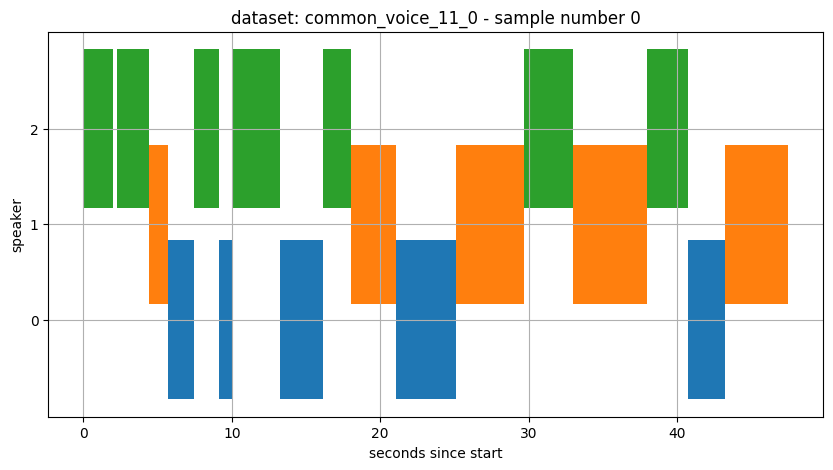

In [9]:
plot_meeting(synthetic_dataset, sample=0)

In [10]:
synthetic_dataset_config.overlap_proba = 0.5
synthetic_dataset_config.overlap_length = 3

synthetic_dataset_config.silence_proba = 1
synthetic_dataset_config.silence_duration = 2

In [11]:
synthetic_dataset = SyntheticDataset(synthetic_dataset_config).generate()

nb speakers in dataset to keep: 3


Filter:   0%|          | 0/26951 [00:00<?, ? examples/s]

100%|██████████| 3/3 [00:00<00:00, 12421.43it/s]
Downloading: "https://github.com/snakers4/silero-vad/zipball/master" to /root/.cache/torch/hub/master.zip
100%|██████████| 2/2 [00:00<00:00, 130.34it/s]


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

In [12]:
from IPython.display import Audio, display

example = synthetic_dataset[0]

display(Audio(example['audio']['array'], rate=example['audio']['sampling_rate']))

In [13]:
from IPython.display import Audio, display

example = synthetic_dataset[1]

display(Audio(example['audio']['array'], rate=example['audio']['sampling_rate']))

In [14]:
synthetic_dataset_config = SyntheticDatasetConfig(
    dataset_name =  "mozilla-foundation/common_voice_11_0",
    subset = "train",
    split = "fa",
    speaker_column_name = "client_id",
    audio_column_name = "audio",
    min_samples_per_speaker = 10,
    nb_speakers_from_dataset = 111,
    sample_rate  = 16000,
    num_meetings = 800,
    nb_speakers_per_meeting = 3,
    segments_per_meeting = 16,
    normalize = True,
    overlap_proba = 0.3,
    overlap_length = 3,
    random_gain = False,
    add_silence = True,
    silence_duration = 3,
    silence_proba = 0.7,
    denoise = False,
    num_proc = 2
)

In [15]:
synthetic_dataset = SyntheticDataset(synthetic_dataset_config).generate()

nb speakers in dataset to keep: 111


Filter (num_proc=2):   0%|          | 0/26951 [00:00<?, ? examples/s]

100%|██████████| 111/111 [00:00<00:00, 185263.73it/s]
Downloading: "https://github.com/snakers4/silero-vad/zipball/master" to /root/.cache/torch/hub/master.zip
100%|██████████| 800/800 [04:19<00:00,  3.09it/s]


Map (num_proc=2):   0%|          | 0/12800 [00:00<?, ? examples/s]

### Load a Pre-Trained Checkpoint

We'll start our fine-tuning run from the pre-trained Whisper `small` checkpoint,
the weights for which we need to load from the Hugging Face Hub. Again, this
is trivial through use of 🤗 Transformers!

In [17]:
synthetic_dataset.push_to_hub("synthetic-speaker-diarization-dataset-fa")

Uploading the dataset shards:   0%|          | 0/3 [00:00<?, ?it/s]

Map:   0%|          | 0/267 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

Map:   0%|          | 0/267 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

Map:   0%|          | 0/266 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/uncleMehrzad/synthetic-speaker-diarization-dataset-fa/commit/ea9f3d34269ac06112e50e645571aadfac591581', commit_message='Upload dataset', commit_description='', oid='ea9f3d34269ac06112e50e645571aadfac591581', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/uncleMehrzad/synthetic-speaker-diarization-dataset-fa', endpoint='https://huggingface.co', repo_type='dataset', repo_id='uncleMehrzad/synthetic-speaker-diarization-dataset-fa'), pr_revision=None, pr_num=None)

### Define a Data Collator

The data collator for a sequence-to-sequence speech model is unique in the sense that it
treats the `input_features` and `labels` independently: the  `input_features` must be
handled by the feature extractor and the `labels` by the tokenizer.

The `input_features` are already padded to 30s and converted to a log-Mel spectrogram
of fixed dimension by action of the feature extractor, so all we have to do is convert the `input_features`
to batched PyTorch tensors. We do this using the feature extractor's `.pad` method with `return_tensors=pt`.

The `labels` on the other hand are un-padded. We first pad the sequences
to the maximum length in the batch using the tokenizer's `.pad` method. The padding tokens
are then replaced by `-100` so that these tokens are **not** taken into account when
computing the loss. We then cut the BOS token from the start of the label sequence as we
append it later during training.

We can leverage the `WhisperProcessor` we defined earlier to perform both the
feature extractor and the tokenizer operations:

Let's initialise the data collator we've just defined:

### Evaluation Metrics

We'll use the word error rate (WER) metric, the 'de-facto' metric for assessing
ASR systems. For more information, refer to the WER [docs](https://huggingface.co/metrics/wer). We'll load the WER metric from 🤗 Evaluate:

We then simply have to define a function that takes our model
predictions and returns the WER metric. This function, called
`compute_metrics`, first replaces `-100` with the `pad_token_id`
in the `label_ids` (undoing the step we applied in the
data collator to ignore padded tokens correctly in the loss).
It then decodes the predicted and label ids to strings. Finally,
it computes the WER between the predictions and reference labels:

### Define the Training Configuration

In the final step, we define all the parameters related to training. For more detail on the training arguments, refer to the Seq2SeqTrainingArguments [docs](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.Seq2SeqTrainingArguments).

**Note**: if one does not want to upload the model checkpoints to the Hub,
set `push_to_hub=False`.

We can forward the training arguments to the 🤗 Trainer along with our model,
dataset, data collator and `compute_metrics` function:

We'll save the processor object once before starting training. Since the processor is not trainable, it won't change over the course of training:

### Training

Training will take approximately 5-10 hours depending on your GPU or the one
allocated to this Google Colab. If using this Google Colab directly to
fine-tune a Whisper model, you should make sure that training isn't
interrupted due to inactivity. A simple workaround to prevent this is
to paste the following code into the console of this tab (_right mouse click_
-> _inspect_ -> _Console tab_ -> _insert code_).

```javascript
function ConnectButton(){
    console.log("Connect pushed");
    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click()
}
setInterval(ConnectButton, 60000);
```

The peak GPU memory for the given training configuration is approximately 15.8GB.
Depending on the GPU allocated to the Google Colab, it is possible that you will encounter a CUDA `"out-of-memory"` error when you launch training.
In this case, you can reduce the `per_device_train_batch_size` incrementally by factors of 2
and employ [`gradient_accumulation_steps`](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.Seq2SeqTrainingArguments.gradient_accumulation_steps)
to compensate.

To launch training, simply execute:

Our best WER is 32.0% - not bad for 8h of training data! We can make our model more accessible on the Hub with appropriate tags and README information.
You can change these values to match your dataset, language and model
name accordingly:

The training results can now be uploaded to the Hub. To do so, execute the `push_to_hub` command and save the preprocessor object we created:

## Building a Demo

Now that we've fine-tuned our model we can build a demo to show
off its ASR capabilities! We'll make use of 🤗 Transformers
`pipeline`, which will take care of the entire ASR pipeline,
right from pre-processing the audio inputs to decoding the
model predictions.

Running the example below will generate a Gradio demo where we
can record speech through the microphone of our computer and input it to
our fine-tuned Whisper model to transcribe the corresponding text:

## Closing Remarks

In this blog, we covered a step-by-step guide on fine-tuning Whisper for multilingual ASR
using 🤗 Datasets, Transformers and the Hugging Face Hub. For more details on the Whisper model, the Common Voice dataset and the theory behind fine-tuning, refere to the accompanying [blog post](https://huggingface.co/blog/fine-tune-whisper). If you're interested in fine-tuning other
Transformers models, both for English and multilingual ASR, be sure to check out the
examples scripts at [examples/pytorch/speech-recognition](https://github.com/huggingface/transformers/tree/main/examples/pytorch/speech-recognition).